<a href="https://colab.research.google.com/github/SpaceZeroed/Direct_Pipe/blob/main/New_Direct_pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp,solve_bvp
import matplotlib.pyplot as plt

dw/dz = a -> dw/dz = w[1]


4.845613041126937e-05 0.00010190910515488506 49063329.44834343
       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  2.002e-02 ...  1.998e+01  2.000e+01]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7c381c1698f0>
             p: None
             y: [[ 0.000e+00  3.118e-04 ...  3.118e-04  0.000e+00]
                 [ 1.557e-02  1.557e-02 ... -1.557e-02 -1.557e-02]
                 [-1.694e-21 -9.405e-06 ... -9.405e-06  0.000e+00]
                 [-4.703e-04 -4.693e-04 ...  4.693e-04  4.703e-04]]
            yp: [[ 1.557e-02  1.557e-02 ... -1.557e-02 -1.557e-02]
                 [-1.694e-21 -9.405e-06 ... -9.405e-06  0.000e+00]
                 [-4.703e-04 -4.693e-04 ...  4.693e-04  4.703e-04]
                 [ 4.846e-05  4.845e-05 ...  4.845e-05  4.846e-05]]
 rms_residuals: [ 2.202e-12  2.201e-12 ...  2.201e-12  2.202e-12]
         niter: 1


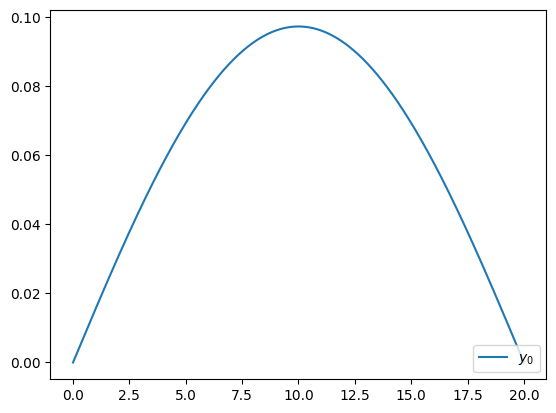


Max deflection  is:0.09727741701556052


In [ ]:
# Решаем краевую задачу через SciPy
l = 20 #длина трубы
m = 7800 * l * np.pi * (0.5**2 - 0.49**2) #масса трубы
q = m * 9.8 / l #погонный вес трубы
N = 5000 #сила сжатия трубы
Jx = np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
E = 2.06 * 10**11 #модуль Юнга
k = 1000 #
print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
def fun(x,w):
  return np.vstack((w[1],w[2],w[3], (+q - k * w[0] + N * w[2] ) / ( E * Jx)))

def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbc = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
y_measles_plot = solbc.sol(x_measles_plot)
plt.plot(x_measles_plot, y_measles_plot[0], label='$y_0$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()

yy = solbc.y[0]
print()
print(f'Max deflection  is:{max(yy)}')

Max deflection  is:0.023383032404762846
Max deflection  is:0.023848741649586534
Max deflection  is:0.024333293643515257
Max deflection  is:0.024837852912129046
Max deflection  is:0.0253636818542833
Max deflection  is:0.025912151239100487
Max deflection  is:0.02648475208454698
Max deflection  is:0.027083109132295165
Max deflection  is:0.027708996176558472
Max deflection  is:0.028364353549065257


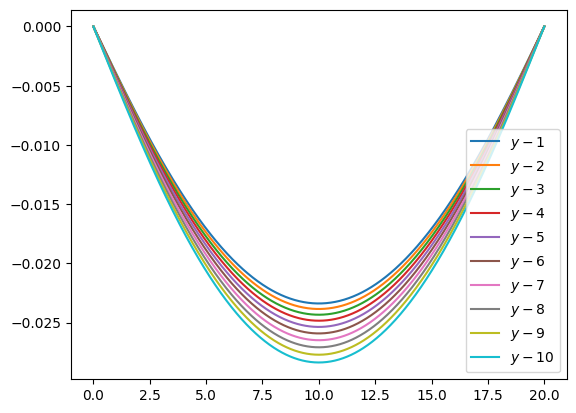

In [ ]:
# Цикл
def fun(x,w):
  return np.vstack((w[1],w[2],w[3], (+q - k * w[0] + N * w[2] ) / ( E * Jx)))

def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
n = 10
x_measles_plot = np.linspace(0, l, totalNodes)
for i in range(1,n+1):
  l = 20 #длина трубы
  m = 7800 * l * np.pi * (0.5**2 - 0.49**2) #масса трубы
  #print(m)
  q = -m * 9.8 / l #погонный вес трубы
  N = (-1)*1e5*i #сила сжатия трубы
  Jx = (np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4))  #момент инерции
  E = 2.06 * 10**11 #модуль Юнга
  k = 10e4 #
  x = np.linspace(0, l, totalNodes)
  y_a = np.zeros((4, x.shape[0]))
  solbci = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
  y_measles_plot = solbci.sol(x_measles_plot)
  plt.plot(x_measles_plot, y_measles_plot[0], label=f'$y-{i}$')
  #plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
  plt.legend(loc='lower right')
  yy = solbci.y[0]
  print(f'Max deflection  is:{max(abs(yy))}')
plt.show()

Тестирую разные диффуры

       message: The maximum number of mesh nodes is exceeded.
       success: False
        status: 1
             x: [ 0.000e+00  2.002e-02 ...  1.998e+01  2.000e+01]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7c3813320590>
             p: None
             y: [[ 0.000e+00  1.284e-03 ... -1.408e-02  0.000e+00]
                 [ 6.414e-02  6.414e-02 ...  7.025e-01  7.039e-01]
                 [ 0.000e+00 -4.302e-05 ...  1.206e-01  0.000e+00]
                 [-2.143e-03 -2.159e-03 ... -4.566e+00 -7.808e+00]]
            yp: [[ 6.414e-02  6.414e-02 ...  7.025e-01  7.039e-01]
                 [ 0.000e+00 -4.302e-05 ...  1.206e-01  0.000e+00]
                 [-2.143e-03 -2.159e-03 ... -4.566e+00 -7.808e+00]
                 [-1.509e-04 -1.482e-03 ... -1.183e+02 -2.153e+02]]
 rms_residuals: [ 7.006e-09  6.994e-09 ...  1.530e-03  1.641e-03]
         niter: 1


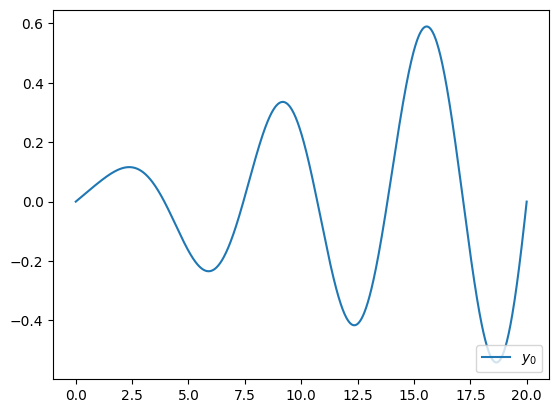

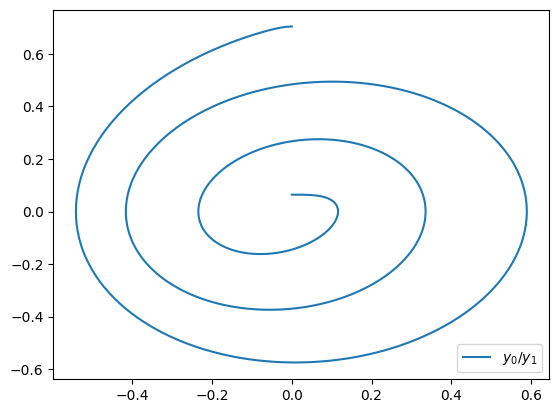


Max deflection  is:0.5895264707747188


In [ ]:
# Решаем краевую задачу через SciPy
k=30
def fun(x,w):
  return np.vstack((w[1],w[2],w[3], k*w[3]-w[2]+w[1]-w[0]+x*np.sin(x)))

def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbc = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
y_measles_plot = solbc.sol(x_measles_plot)
plt.plot(x_measles_plot, y_measles_plot[0], label='$y_0$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()
plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
plt.legend(loc='lower right')
plt.show()
yy = solbc.y[0]
print()
print(f'Max deflection  is:{max(yy)}')